# Document preprocessors

This notebooks present the creation of classes a methods to create preprocessors to take the PDF documents and chunk them into structured data to be stored for retrieval. The main objective is designing objects that are easy to implement and test (as well a select hiperparameters if needed) so that the best case can be used for the present scenario.

There are many posibilities for how to chunk documents, so it's necesary to mention that only this alternatives are considered in this notebook:

* Using sentences as chunks
* Using propositions as chunks
* Using Semanthic chunking with sentences
* Using Semanthic chunking respecting the order with sentences

With the mention, but not the implementation of:

* Using Semanthic chunking with propositions
* Using Semanthic chunking respecting the order with propositions

The decisition of not exploring the porpositions alternatives further is due to the cost in time and money it represents. For alternative to be evaliated we will tune the parameters (when needed) and then compare the tuned strategies using to check which alternative achieves the best retireval metrics. Strategies found here are elaboarated form different sources, but a main reference is: https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb by Greg Kamradt

## libaries and environment

In [1]:
import os
import PyPDF2
import hashlib
import json
import google.generativeai as genai
import time
import numpy as np

from nltk import sent_tokenize
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Union

load_dotenv(override=True)
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
project_path = os.path.dirname(os.getcwd())
docs_path = os.path.join(project_path, 'docs')

genai.configure(api_key=GOOGLE_API_KEY)

/workspaces/pdf-papers-assistant-project/llm-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Document reading

Reading the paper "Attention is all you need" to be used for the chunking strategies designed

In [2]:
def extract_text_from_pdf(pdf_path:str) -> str:
    """Function to extract the text from a given PDF

    Args:
        pdf_path (str): PDF file to be processed

    Returns:
        str: Document's text
    """
    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
        return text



In [3]:
topic = 'deeplearning'
paper = 'attention_is_all_you_need.pdf'
number_in_topic = 3
doc_id = hashlib.sha256(f'{topic}-{paper}-{number_in_topic}'.encode('utf-8')).hexdigest()

pdf_path = os.path.join(docs_path, topic, paper)

text = extract_text_from_pdf(pdf_path)

In [4]:
print(text)

Attention Is All You Need
Ashish Vaswani
Google Brain
avaswani@google.comNoam Shazeer
Google Brain
noam@google.comNiki Parmar
Google Research
nikip@google.comJakob Uszkoreit
Google Research
usz@google.com
Llion Jones
Google Research
llion@google.comAidan N. Gomezy
University of Toronto
aidan@cs.toronto.eduŁukasz Kaiser
Google Brain
lukaszkaiser@google.com
Illia Polosukhinz
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring signiﬁcantly
less time to train. Our model achiev

## Sentence tokenization

We start with a simple approach to split the text into sentences using nltk: 

In [7]:
sentences = sent_tokenize(text)

In [8]:
sentences[:3]

['Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.',
 'The best\nperforming models also connect the encoder and decoder through an attention\nmechanism.',
 'We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely.']

Now, we will structure it into a more optimal format for the posterior retrieval work:

In [7]:
sentence_dicts = []

for n, sentence in enumerate(sentences):
    sentence_dicts.append({
        "doc_id": doc_id,
        "chunk":n,
        "sentence":sentence            
    })

In [8]:
sentence_dicts[:3]

[{'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 0,
  'sentence': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 1,
  'sentence': 'The best\nperforming models also connect the encoder and decoder through an attention\nmechanism.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce1

In [9]:
def get_sentences(text:str, doc_id:str) -> List[dict]:
    """Function that takes a text an chunks it into
    sentences, then structures it as a list of dictionaries

    Args:
        text (str): Text to be splitted
        doc_id (str): sha256 codified ID for each document

    Returns:
        List[dict]: List of dictionaries containing the
        document id, chunk_number and sentence each
    """
    sentence_dicts = []
    sentences = sent_tokenize(text) 
    

    for n, sentence in enumerate(sentences):
        sentence_dicts.append({
            "doc_id": doc_id,
            "chunk":n + 1,
            "text":sentence            
        })
        
    return sentence_dicts

In [10]:
sentences = get_sentences(text, doc_id)
sentences[:3]

[{'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 1,
  'text': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 2,
  'text': 'The best\nperforming models also connect the encoder and decoder through an attention\nmechanism.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b33317

In [40]:
test_string = """
This is a test string that's designed to be easily processed by the different methods in order to get unit tests.

The idea is to passed this text to each preprocessor and then use the output to design simple tests.

The tests will be run using pytests.

Notice that since this code is designed for articles, which are expected to be large texts, the present text string cannot be a single short string.

To make the string larger, the following text is introduced:

One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]
"""

In [19]:
get_sentences(test_string, "asdfgh123") == [{'doc_id': 'asdfgh123',
  'chunk': 1,
  'text': "\nThis is a test string that's designed to be easily processed by the different methods in order to get unit tests."},
 {'doc_id': 'asdfgh123',
  'chunk': 2,
  'text': 'The idea is to passed this text to each preprocessor and then use the output to design simple tests.'},
 {'doc_id': 'asdfgh123',
  'chunk': 3,
  'text': 'The tests will be run using pytests.'},
 {'doc_id': 'asdfgh123',
  'chunk': 4,
  'text': 'Notice that since this code is designed for articles, which are expected to be large texts, the present text string cannot be a single short string.'},
 {'doc_id': 'asdfgh123',
  'chunk': 5,
  'text': "To make the string larger, the following text is introduced:\n\nOne of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."},
 {'doc_id': 'asdfgh123',
  'chunk': 6,
  'text': 'Teachers and coaches implicitly told us the returns were linear.'},
 {'doc_id': 'asdfgh123',
  'chunk': 7,
  'text': '"You get out," I heard a thousand times, "what you put in."'},
 {'doc_id': 'asdfgh123',
  'chunk': 8,
  'text': 'They meant well, but this is rarely true.'},
 {'doc_id': 'asdfgh123',
  'chunk': 9,
  'text': "If your product is only half as good as your competitor's, you don't get half as many customers."},
 {'doc_id': 'asdfgh123',
  'chunk': 10,
  'text': 'You get no customers, and you go out of business.'},
 {'doc_id': 'asdfgh123',
  'chunk': 11,
  'text': "It's obviously true that the returns for performance are superlinear in business."},
 {'doc_id': 'asdfgh123',
  'chunk': 12,
  'text': 'Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true.'},
 {'doc_id': 'asdfgh123',
  'chunk': 13,
  'text': "But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented."},
 {'doc_id': 'asdfgh123',
  'chunk': 14,
  'text': 'We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity.'},
 {'doc_id': 'asdfgh123',
  'chunk': 15,
  'text': 'In all of these, the rich get richer.'},
 {'doc_id': 'asdfgh123', 'chunk': 16, 'text': '[1]'}]

True

## Propositions tokenization

The second alternative explores using the sentences structured as propositions, a concept that extracts stand alone statements form a raw piece of text:

e.g. "Greg went to the park. He likes walking" -> ["Greg went to the park.", "Greg likes walking"]

More about this concept can be found in the research paper https://arxiv.org/pdf/2312.06648



In [119]:
model = 'models/gemini-1.5-flash-latest'
llm_model = genai.GenerativeModel(model)
generation_config = genai.types.GenerationConfig(
    candidate_count=1,
    temperature=0
)
safety_settings={
    'HARM_CATEGORY_HARASSMENT': 'BLOCK_NONE',
    'HARM_CATEGORY_HATE_SPEECH': 'BLOCK_NONE',
    'HARM_CATEGORY_SEXUALLY_EXPLICIT': 'BLOCK_NONE',
    'HARM_CATEGORY_DANGEROUS_CONTENT': 'BLOCK_NONE'
}

def llm(prompt:str) -> str:
    """Method to get the llm response given a prompt

    Args:
        prompt (str): Input prompt
        
    Returns:
        str: Response given by the LLM
    """
    
    responses = llm_model.generate_content(
        contents=prompt,
        safety_settings=safety_settings,
        generation_config=generation_config
    )

    return "".join(response.text for response in responses)

In [112]:
PROPOSAL_INDEXING_PROMPT = """
SYSTEM
Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of
context.
1. Split compound sentence into simple sentences. Maintain the original phrasing from the input
whenever possible.
2. For any named entity that is accompanied by additional descriptive information, separate this
information into its own distinct proposition.
3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences
and replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the
entities they refer to.
4. Present the results as a list of strings, formatted in JSON. Make sure it's a parseable dictionary
5. If the context is too short, return it as a list with a single string.

Example:

Input: Title: ¯Eostre. Section: Theories and interpretations, Connection to Easter Hares. Content:
The earliest evidence for the Easter Hare (Osterhase) was recorded in south-west Germany in
1678 by the professor of medicine Georg Franck von Franckenau, but it remained unknown in
other parts of Germany until the 18th century. Scholar Richard Sermon writes that "hares were
frequently seen in gardens in spring, and thus may have served as a convenient explanation for the
origin of the colored eggs hidden there for children. Alternatively, there is a European tradition
that hares laid eggs, since a hare’s scratch or form and a lapwing’s nest look very similar, and
both occur on grassland and are first seen in the spring. In the nineteenth century the influence
of Easter cards, toys, and books was to make the Easter Hare/Rabbit popular throughout Europe.
German immigrants then exported the custom to Britain and America where it evolved into the
Easter Bunny."
Output: [ "The earliest evidence for the Easter Hare was recorded in south-west Germany in
1678 by Georg Franck von Franckenau.", "Georg Franck von Franckenau was a professor of
medicine.", "The evidence for the Easter Hare remained unknown in other parts of Germany until
the 18th century.", "Richard Sermon was a scholar.", "Richard Sermon writes a hypothesis about
the possible explanation for the connection between hares and the tradition during Easter", "Hares
were frequently seen in gardens in spring.", "Hares may have served as a convenient explanation
for the origin of the colored eggs hidden in gardens for children.", "There is a European tradition
that hares laid eggs.", "A hare’s scratch or form and a lapwing’s nest look very similar.", "Both
hares and lapwing’s nests occur on grassland and are first seen in the spring.", "In the nineteenth
century the influence of Easter cards, toys, and books was to make the Easter Hare/Rabbit popular
throughout Europe.", "German immigrants exported the custom of the Easter Hare/Rabbit to
Britain and America.", "The custom of the Easter Hare/Rabbit evolved into the Easter Bunny in
Britain and America."]

HUMAN
Decompose the following:
{input}
"""

In [113]:
prompt = PROPOSAL_INDEXING_PROMPT.format(input=sentences[2]['text'])
print(prompt)


SYSTEM
Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of
context.
1. Split compound sentence into simple sentences. Maintain the original phrasing from the input
whenever possible.
2. For any named entity that is accompanied by additional descriptive information, separate this
information into its own distinct proposition.
3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences
and replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the
entities they refer to.
4. Present the results as a list of strings, formatted in JSON. Make sure it's a parseable dictionary
5. If the context is too short, return it as a list with a single string.

Example:

Input: Title: ¯Eostre. Section: Theories and interpretations, Connection to Easter Hares. Content:
The earliest evidence for the Easter Hare (Osterhase) was recorded in south-west Germany in
1678 by the professor of medici

In [97]:
response = llm(prompt)
response = json.loads(response.replace('```json', '').replace('```', ''))
response


['We propose a new simple network architecture.',
 'The network architecture is called the Transformer.',
 'The Transformer is based solely on attention mechanisms.',
 'The Transformer dispenses with recurrence and convolutions entirely.']

In [78]:
print(sentences[2]['text'])

We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely.


In [116]:
def get_sentence_propositions(sentence:str) -> List[str]:
    """Function that takes a sentence and converts it into
    propositions using an LLM model

    Args:
        sentence (str): Sentence to be processed

    Returns:
        List[str]: List of propositions
    """
    prompt = PROPOSAL_INDEXING_PROMPT.format(input=sentence)
    response = llm(prompt)
    try:
        formated_response = json.loads(response.replace('```json', '').replace('```', ''))
    except Exception as e:
        print(f"Sentence: {sentence}")
        print(f"Model response: {response}")        
        raise ValueError(f"The following error raised: \n{e}")
    return formated_response

In [101]:
print(sentences[2]['text'])

We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely.


In [102]:
get_sentence_propositions(sentences[2]['text'])

In [120]:
def get_propositions(text:str, doc_id:str) -> List[dict]:
    """Function that takes a text and chunks it into
    propositions, then structures it as a list of dictionaries

    Args:
        text (str): Text to be splitted
        doc_id (str): sha256 codified ID for each document

    Returns:
        List[dict]: List of dictionaries containing the
        document id, chunk_number and proposition each
    """
    doc_dicts = []
    sentences = sent_tokenize(text)
    
    chunk = 0
    
    for sentence in sentences:
        propositions = get_sentence_propositions(sentence)
        time.sleep(2)
        
        for proposition in propositions:
            chunk += 1
            doc_dicts.append({
                "doc_id": doc_id,
                "chunk": chunk,
                "text": proposition            
            })
        
    return doc_dicts

The time.sleep(2) line presented in the function is neccesary since this code is implemented using free resources from google. If a full account is used it may be removed but the implementation cost will raise. 

In [121]:
propositions = get_propositions(text, doc_id)

In [123]:
propositions[:3]

[{'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 1,
  'text': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 2,
  'text': 'Ashish Vaswani is a researcher at Google Brain.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 3,
  'text': 'Noam Shazeer is a researcher at Google Brain.'}]

In [124]:
import pandas as pd

propositions_df = pd.DataFrame(propositions)
propositions_df.head()

,doc_id,chunk,text
0,9bce526f29338990687593c102f3a43ca5cd4b63f626d5...,1,The dominant sequence transduction models are ...
1,9bce526f29338990687593c102f3a43ca5cd4b63f626d5...,2,Ashish Vaswani is a researcher at Google Brain.
2,9bce526f29338990687593c102f3a43ca5cd4b63f626d5...,3,Noam Shazeer is a researcher at Google Brain.
3,9bce526f29338990687593c102f3a43ca5cd4b63f626d5...,4,Niki Parmar is a researcher at Google Research.
4,9bce526f29338990687593c102f3a43ca5cd4b63f626d5...,5,Jakob Uszkoreit is a researcher at Google Rese...


In [126]:
propositions_df.to_csv(os.path.join(project_path, 'data', 'propositions.csv'))

## IMPORTANT NOTICE

For the present excercise getting the porpositions for a single article took around 45 minutes. Given the time restrictions (the project's deadline) and the fact that I am trying to develop the project without demanding costs this alternative will NOT BE CONSIDERED, evethough it may present very good results

## Semantic chunking with sentences

In this case we will embed the sentences and then group them using a clustering strategy. The clusters will correspond to the chunks in our document

In [127]:
sentences = sent_tokenize(text)

# Create a sentence embedding model
model = SentenceTransformer('all-mpnet-base-v2')

# Convert sentences to vectors
embeddings= model.encode(sentences)

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


We will automate the selection of the number of clusters, so we will use the silhoutte_score (instead of an elbow plot) to check the best number of clusters in this case 

In [140]:
silhouette_scores = []
for i in range(2, 200):  # Start from 2 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)
    
clusters = np.argmax(silhouette_scores) + 2

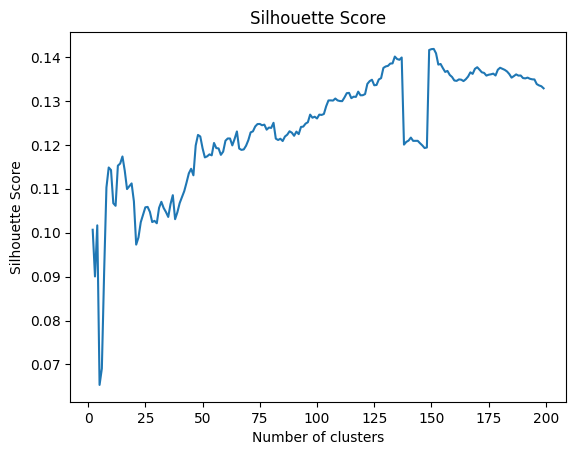

In [141]:
import matplotlib.pyplot as plt

plt.plot(range(2, 200), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Now, we will create the chunks 

In [142]:
clusters

151

In [146]:
kmeans = KMeans(n_clusters=clusters, random_state=0)
kmeans.fit(embeddings)

# Create chunks based on cluster assignments
chunks = [[] for _ in range(clusters)]
for i, cluster_id in enumerate(kmeans.labels_):
    chunks[cluster_id].append(sentences[i])

chunks_dicts = []
for i, chunk in enumerate(chunks):
    chunks_dicts.append({
        "doc_id": doc_id,
        "chunk": i + 1,
        "text": "\n".join(chunk)
    })


In [23]:
def get_semantic_chunks(text:str, doc_id:str) -> List[dict]:
    """Function that takes a text and splitts it into chunks
    grouping them by sematic proximiy (using kmeans)

    Args:
        text (str): Text to be splitted
        doc_id (str): sha256 codified ID for each document

    Returns:
        List[dict]: List of dictionaries containing the
        document id, chunk_number and text each
    """
    
    sentences = sent_tokenize(text)

    # Create a sentence embedding model
    model = SentenceTransformer('all-mpnet-base-v2')

    # Convert sentences to vectors
    embeddings = model.encode(sentences)
    
    
    silhouette_scores = []
    for i in range(2, 200):  # Start from 2 clusters
        try:
            kmeans = KMeans(n_clusters=i, random_state=0)
            kmeans.fit(embeddings)
            score = silhouette_score(embeddings, kmeans.labels_)
            silhouette_scores.append(score)
        except:
            break
        
    clusters = np.argmax(silhouette_scores) + 2
    
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    kmeans.fit(embeddings)

    # Create chunks based on cluster assignments
    chunks = [[] for _ in range(clusters)]
    for i, cluster_id in enumerate(kmeans.labels_):
        chunks[cluster_id].append(sentences[i])

    chunks_dicts = []
    for i, chunk in enumerate(chunks):
        chunks_dicts.append({
            "doc_id": doc_id,
            "chunk": i + 1,
            "text": "\n".join(chunk)
        })
        
    return chunks_dicts
    

In [148]:
semantic_chunks = get_semantic_chunks(text, doc_id)

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [149]:
semantic_chunks[:3]

[{'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 1,
  'text': 'We used a beam size of 21and\x0b= 0:3\nfor both WSJ only and the semi-supervised setting.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 2,
  'text': 'The Transformer allows for signiﬁcantly more parallelization and can reach a new state of the art in\ntranslation quality after being trained for as little as twelve hours on eight P100 GPUs.\nFor translation tasks, the Transformer can be trained signiﬁcantly faster than architectures based\non recurrent or convolutional layers.'},
 {'doc_id': '9bce526f29338990687593c102f3a43ca5cd4b63f626d5872c48ce102b333170',
  'chunk': 3,
  'text': '[4]Jianpeng Cheng, Li Dong, and Mirella Lapata.'}]

In [24]:
get_semantic_chunks(test_string, "asdfgh123") == [{'doc_id': 'asdfgh123',
  'chunk': 1,
  'text': "If your product is only half as good as your competitor's, you don't get half as many customers.\nYou get no customers, and you go out of business."},
 {'doc_id': 'asdfgh123',
  'chunk': 2,
  'text': 'Teachers and coaches implicitly told us the returns were linear.'},
 {'doc_id': 'asdfgh123',
  'chunk': 3,
  'text': 'Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true.\nWe see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity.\nIn all of these, the rich get richer.'},
 {'doc_id': 'asdfgh123',
  'chunk': 4,
  'text': "To make the string larger, the following text is introduced:\n\nOne of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."},
 {'doc_id': 'asdfgh123',
  'chunk': 5,
  'text': "\nThis is a test string that's designed to be easily processed by the different methods in order to get unit tests.\nNotice that since this code is designed for articles, which are expected to be large texts, the present text string cannot be a single short string."},
 {'doc_id': 'asdfgh123', 'chunk': 6, 'text': '[1]'},
 {'doc_id': 'asdfgh123',
  'chunk': 7,
  'text': 'They meant well, but this is rarely true.'},
 {'doc_id': 'asdfgh123',
  'chunk': 8,
  'text': "It's obviously true that the returns for performance are superlinear in business.\nBut superlinear returns for performance are a feature of the world, not an artifact of rules we've invented."},
 {'doc_id': 'asdfgh123',
  'chunk': 9,
  'text': '"You get out," I heard a thousand times, "what you put in."'},
 {'doc_id': 'asdfgh123',
  'chunk': 10,
  'text': 'The idea is to passed this text to each preprocessor and then use the output to design simple tests.\nThe tests will be run using pytests.'}]

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


True

## Ordered semantic chunking

This time we will set the clusters sequenially, though still grouping semantically.

We start by getting the sentences and turn them into a dictionary list to handle other values to be added.

In [7]:
sentences = sent_tokenize(text)
# Create a sentence embedding model
model = SentenceTransformer('all-mpnet-base-v2')

embeddings = model.encode(sentences)

sentences = [
    {'index': i, 'sentence': sentence} for i, sentence in enumerate(sentences)
]
sentences[:3]

/workspaces/pdf-papers-assistant-project/llm-project/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'index': 0,
  'sentence': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.'},
 {'index': 1,
  'sentence': 'The best\nperforming models also connect the encoder and decoder through an attention\nmechanism.'},
 {'index': 2,
  'sentence': 'We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely.'}]

In [8]:
def combine_sentences(sentences:List[dict], buffer_size:int=1) -> List[dict]:
    """Function that combines sentences according to a buffer size to give
    stability to the distance comparison between chunks

    Args:
        sentences (List[dict]): List of dictionaries where each one contains
            a sentece an it's index
        buffer_size (int, optional): _description_. Number of sentences to combine
            from before and after the present one

    Returns:
        List[dict]: List of dictionaries where each one contains
            a sentece, it's index and the combined text
    """
    model = SentenceTransformer('all-mpnet-base-v2')
    
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence
        sentences[i]['combined_sentence_embedding'] = model.encode(combined_sentence)

    return sentences

In [9]:
sentences = combine_sentences(sentences)
sentences[:3]

[{'index': 0,
  'sentence': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.',
  'combined_sentence': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.t

refactoring for effiency

In [10]:
def combine_sentences(
    sentences:List[dict], 
    model:SentenceTransformer,
    buffer_size:int=1
) -> List[dict]:
    """Function that combines sentences according to a buffer size to give
    stability to the distance comparison between chunks

    Args:
        sentences (List[dict]): List of dictionaries where each one contains
            a sentece an it's index
        model (SentenceTransformer): Sentence embedding model.
        buffer_size (int, optional): _description_. Number of sentences to combine
            from before and after the present one
        
    Returns:
        List[dict]: List of dictionaries where each one contains
            a sentece, it's index and the combined text
    """
    
    combined_sentences = []
    n = len(sentences)
    # Precompute the combined sentences
    for i in range(n):
        # Get the range of indices for sentences before, current, and after
        start_idx = max(0, i - buffer_size)
        end_idx = min(len(sentences), i + 1 + buffer_size)
        
        # Combine sentences using list comprehension and str.join
        combined_sentences.append(' '.join([sentences[j]['sentence'] for j in range(start_idx, end_idx)]))
    
    combined_sentences_embeddings = list(map(lambda x: model.encode(x), combined_sentences))
    # # Store the combined sentence and its embedding in the current sentence dict
    for i in range(n):
        sentences[i]['combined_sentence'] = combined_sentences[i]
        sentences[i]['combined_sentence_embedding'] = combined_sentences_embeddings[i]
        
    return sentences

In [11]:
sentences_2 = combine_sentences(sentences, model=model)
sentences_2[:3]

[{'index': 0,
  'sentence': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.',
  'combined_sentence': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.t

In [12]:
sentences[-1] == sentences_2[-1]

True

Now, we set breaking points using the cosine distance between combined sentences embeddings. In this case we will set the breaking points using a percentile of the cosine similarities, so that we chunk in the points that are in a certain percentile of the least similar texts to the next one.

In [13]:
def calculate_cosine_similarities(sentences:List[dict]) -> Union[List, List[dict]]:
    """_summary_

    Args:
        sentences (List[dict]): List of dictionaries where each one contains
            a sentece, it's index and the combined text

    Returns:
        Union[List, List[dict]]: A list of all similarities and a list of 
        dictionaries where each one contains a sentece, it's index, the combined text
        and embedding and the embedding's similarity with the next.
    """
    similarities = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]

        # Append cosine distance to the list
        similarities.append(similarity)

        # Store distance in the dictionary
        sentences[i]['similarity_with_next'] = similarity

    # Optionally handle the last sentence
    #sentences[-1]['similarity_with_next'] = None  # or a default value

    return similarities, sentences

In [14]:
similarities, sentences = calculate_cosine_similarities(sentences)

In [15]:
breakpoint_percentile = 5
threshold = np.percentile(similarities, breakpoint_percentile)
threshold

np.float32(0.42526037)

In [33]:
breakpoints = np.where(similarities < threshold)[0]

In [34]:
len(breakpoints)

18

In [205]:
len(np.diff(np.concatenate(([0], breakpoints, [len(sentences)]))))

19

In [206]:
sentences_per_cluster = np.diff(
    np.concatenate(([0], breakpoints, [len(sentences)]))
)


In [207]:
labels = np.concatenate(
    [np.repeat((i+1), n) for i,n in enumerate(sentences_per_cluster)]
)

In [16]:
def get_sequential_clusters(
    sentences:List[str],
    model:SentenceTransformer, 
    buffer_size:int=1, 
    breakpoint_percentile:int=5    
) -> np.ndarray:
    """Function to get the clusters for a semantic chunking maintaining
    the sentences order

    Args:
        sentences (List[str]): List of sentences
        model (SentenceTransformer, optional): Sentence embedding model.
        buffer_size (int, optional): _description_. Number of sentences to combine
            from before and after the present one
        breakpoint_percentile (int, optional): _description_. Defaults to 5.
         
    Returns:
        np.ndarray: Array containing the clusters' labels
    """

    sentences = [
        {'index': i, 'sentence': sentence} for i, sentence in enumerate(sentences)
    ]
    
    sentences = combine_sentences(sentences, model=model, buffer_size=buffer_size)
    
    similarities, sentences = calculate_cosine_similarities(sentences)
    
    threshold = np.percentile(similarities, breakpoint_percentile)
    
    breakpoints = np.where(similarities < threshold)[0]
    
    sentences_per_cluster = np.diff(
        np.concatenate(([0], breakpoints, [len(sentences)]))
    )
    
    labels = np.concatenate(
        [np.repeat((i+1), n) for i,n in enumerate(sentences_per_cluster)]
    )
        
    return labels
        

In [36]:
sentences = sent_tokenize(text)
clusters_labels = get_sequential_clusters(sentences, 1, 5)

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:
silhouette_score(embeddings, clusters_labels)

-0.06269553

In [211]:
silhouette_scores = []
parameters = []
for buffer_size in [1,2,3]:
    for breakpoint_percentile in [5, 10, 15]:
        clusters_labels = get_sequential_clusters(sentences, buffer_size, breakpoint_percentile)
        score = silhouette_score(embeddings, clusters_labels)
        silhouette_scores.append(score)
        parameters.append({
            "buffer_size": buffer_size,
            "breakpoint_percentile": breakpoint_percentile
        })
    
best_params = parameters[np.argmax(silhouette_scores)]

In [212]:
clusters_labels = get_sequential_clusters(sentences, **best_params)

In [213]:
clusters_labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [214]:
best_params

{'buffer_size': 3, 'breakpoint_percentile': 5}

In [222]:
# Create chunks based on cluster assignments
chunks = [[] for _ in range(clusters_labels.max())]
for i, cluster_id in enumerate(clusters_labels):
    chunks[cluster_id-1].append(sentences[i])

chunks_dicts = []
for i, chunk in enumerate(chunks):
    chunks_dicts.append({
        "doc_id": doc_id,
        "chunk": i + 1,
        "text": "\n".join(chunk)
    })
    


In [17]:
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=4)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [18]:

def get_sequential_semantic_chunks(text:str, doc_id:str) -> List[dict]:
    """Function that takes a text and splitts it into chunks
    using semantic grouping and maintaining the sentences order

    Args:
        text (str): Text to be splitted
        doc_id (str): sha256 codified ID for each document

    Returns:
        List[dict]: List of dictionaries containing the
        document id, chunk_number and text each
    """
    sentences = sent_tokenize(text)
    # Create a sentence embedding model
    model = SentenceTransformer('all-mpnet-base-v2')

    embeddings = model.encode(sentences)
    
    silhouette_scores = []
    parameters = []
    for buffer_size in [1,2,3]:
        for breakpoint_percentile in [5, 10]:
            clusters_labels = get_sequential_clusters(
                sentences, model, buffer_size, breakpoint_percentile
            )
            score = silhouette_score(embeddings, clusters_labels)
            silhouette_scores.append(score)
            parameters.append({
                "buffer_size": buffer_size,
                "breakpoint_percentile": breakpoint_percentile
            })
        
    best_params = parameters[np.argmax(silhouette_scores)]
    clusters_labels = get_sequential_clusters(sentences, **best_params)
    
    # Create chunks based on cluster assignments
    chunks = [[] for _ in range(clusters_labels.max())]
    for i, cluster_id in enumerate(clusters_labels):
        chunks[cluster_id-1].append(sentences[i])

    chunks_dicts = []
    for i, chunk in enumerate(chunks):
        chunks_dicts.append({
            "doc_id": doc_id,
            "chunk": i + 1,
            "text": "\n".join(chunk)
        })
        
    return chunks_dicts

In [41]:
get_sequential_semantic_chunks(test_string, "asdfgh123") == [{'doc_id': 'asdfgh123',
  'chunk': 1,
  'text': "\nThis is a test string that's designed to be easily processed by the different methods in order to get unit tests.\nThe idea is to passed this text to each preprocessor and then use the output to design simple tests.\nThe tests will be run using pytests.\nNotice that since this code is designed for articles, which are expected to be large texts, the present text string cannot be a single short string.\nTo make the string larger, the following text is introduced:\n\nOne of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."},
 {'doc_id': 'asdfgh123',
  'chunk': 2,
  'text': 'Teachers and coaches implicitly told us the returns were linear.\n"You get out," I heard a thousand times, "what you put in."\nThey meant well, but this is rarely true.\nIf your product is only half as good as your competitor\'s, you don\'t get half as many customers.\nYou get no customers, and you go out of business.\nIt\'s obviously true that the returns for performance are superlinear in business.\nSome think this is a flaw of capitalism, and that if we changed the rules it would stop being true.\nBut superlinear returns for performance are a feature of the world, not an artifact of rules we\'ve invented.\nWe see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity.\nIn all of these, the rich get richer.\n[1]'}]

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base

True

In [43]:
get_sequential_semantic_chunks(text, "44894a651sf")

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base

[{'doc_id': '44894a651sf',
  'chunk': 1,
  'text': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.\nThe best\nperforming models also connect the encoder and decoder through an attention\nmechanism.\nWe propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely.\nExperiments on two machine translation tasks show these models to\nbe superior i

In [34]:

def get_sequential_semantic_chunks_paral(
    text:str, 
    doc_id:str,
    workers:int=4
) -> List[dict]:
    """Function that takes a text and splitts it into chunks
    using semantic grouping and maintaining the sentences order

    Args:
        text (str): Text to be splitted
        doc_id (str): sha256 codified ID for each document
        workers (int, optional): Number of workers to use. Defaults to 4.

    Returns:
        List[dict]: List of dictionaries containing the
        document id, chunk_number and text each
    """
    sentences = sent_tokenize(text)
    # Create a sentence embedding model
    model = SentenceTransformer('all-mpnet-base-v2')
    pool = ThreadPoolExecutor(max_workers=workers)

    embeddings = model.encode(sentences)
    
    if len(sentences) < 2:
        return [{
            "doc_id": doc_id,
            "chunk": 1,
            "text": text
        }]
    
    silhouette_scores = []
    parameters = [
        {"buffer_size":buffer_size, "breakpoint_percentile":breakpoint_percentile} 
        for buffer_size in [1,2,3] for breakpoint_percentile in [5, 10]
    ]
    def get_silhoutte_score(enum_param):
        i, params = enum_param
        try:
            clusters_labels = get_sequential_clusters(sentences, model, **params)
            score = silhouette_score(embeddings, clusters_labels)
        except:
            score = -1
        return i, score
    
    results_list = map_progress(pool, list(enumerate(parameters)), get_silhoutte_score)
    silhouette_scores = [score for _, score in results_list]
    best_index = results_list[np.argmax(silhouette_scores)][0]
    best_params = parameters[best_index]
    clusters_labels = get_sequential_clusters(sentences, model, **best_params)
    
    # Create chunks based on cluster assignments
    chunks = [[] for _ in range(clusters_labels.max())]
    for i, cluster_id in enumerate(clusters_labels):
        chunks[cluster_id-1].append(sentences[i])

    chunks_dicts = []
    for i, chunk in enumerate(chunks):
        chunks_dicts.append({
            "doc_id": doc_id,
            "chunk": i + 1,
            "text": "\n".join(chunk)
        })
        
    return chunks_dicts

In [87]:
get_sequential_semantic_chunks_paral(test_string, "asdfgh123") == [{'doc_id': 'asdfgh123',
  'chunk': 1,
  'text': "\nThis is a test string that's designed to be easily processed by the different methods in order to get unit tests.\nThe idea is to passed this text to each preprocessor and then use the output to design simple tests.\nThe tests will be run using pytests.\nNotice that since this code is designed for articles, which are expected to be large texts, the present text string cannot be a single short string.\nTo make the string larger, the following text is introduced:\n\nOne of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."},
 {'doc_id': 'asdfgh123',
  'chunk': 2,
  'text': 'Teachers and coaches implicitly told us the returns were linear.\n"You get out," I heard a thousand times, "what you put in."\nThey meant well, but this is rarely true.\nIf your product is only half as good as your competitor\'s, you don\'t get half as many customers.\nYou get no customers, and you go out of business.\nIt\'s obviously true that the returns for performance are superlinear in business.\nSome think this is a flaw of capitalism, and that if we changed the rules it would stop being true.\nBut superlinear returns for performance are a feature of the world, not an artifact of rules we\'ve invented.\nWe see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity.\nIn all of these, the rich get richer.\n[1]'}]

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


True

In [55]:
get_sequential_semantic_chunks_paral(text, "44894a651sf", workers=8)

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 6/6 [03:49<00:00, 38.33s/it] 
c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'doc_id': '44894a651sf',
  'chunk': 1,
  'text': 'Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder.\nThe best\nperforming models also connect the encoder and decoder through an attention\nmechanism.\nWe propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely.\nExperiments on two machine translation tasks show these models to\nbe superior i

In [58]:
parameters = [
    {"buffer_size":buffer_size, "breakpoint_percentile":breakpoint_percentile} 
    for buffer_size in [1,2,3] for breakpoint_percentile in [5, 10]
]
t_l = []
for i, par in enumerate(parameters):
    t_l.append({i:1})

In [64]:
for k in t_l[0].keys():
    print(k)

0


In [66]:
type(k)


int

In [20]:
get_sequential_semantic_chunks_paral(
    text="gsaogdsgsg. ",
    doc_id="fs8d9g4615"
)

/workspaces/pdf-papers-assistant-project/llm-project/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00, 18.54it/s]


IndexError: index -1 is out of bounds for axis 0 with size 0

In [92]:
len(model.encode(sent_tokenize("gsaogdsgsg. ")))

1

In [23]:
example_text = "Sample text to replicate the error generated while indexing the documents. "

In [25]:
sample_emb = model.encode(sent_tokenize(example_text))
sample_sent = sent_tokenize(example_text)

In [26]:
sample_sentences = [
    {'index': i, 'sentence': sentence} for i, sentence in enumerate(sample_sent)
]
sample_sentences

[{'index': 0,
  'sentence': 'Sample text to replicate the error generated while indexing the documents.'}]

In [27]:
sample_sentences = combine_sentences(sample_sentences, model=model)
sample_sentences

[{'index': 0,
  'sentence': 'Sample text to replicate the error generated while indexing the documents.',
  'combined_sentence': 'Sample text to replicate the error generated while indexing the documents.',
  'combined_sentence_embedding': array([ 5.91634735e-02, -7.02271354e-04, -4.25744662e-03,  1.27891125e-02,
         -1.50460610e-03,  5.98317832e-02,  7.31393043e-03,  7.70593286e-02,
          2.27259635e-03, -5.23741171e-02,  4.38944325e-02,  2.25493442e-02,
         -1.47026833e-02, -2.09834334e-02, -4.69661243e-02, -1.03629082e-02,
          4.76603583e-02,  7.30152358e-04, -1.48252547e-02, -3.58342566e-02,
         -2.92396694e-02,  5.08151539e-02,  2.54428443e-02, -1.50087336e-02,
         -1.12652816e-02, -2.40226351e-02, -2.52964161e-02,  2.45932303e-02,
         -1.72031857e-02, -7.40467608e-02,  3.78734581e-02, -8.18419084e-03,
         -1.69592593e-02,  2.74175331e-02,  1.42689066e-06, -4.80038412e-02,
         -8.31129961e-03,  1.96435559e-03, -8.90857773e-04, -4.030162

In [28]:
samp_simil, sample_sentences = calculate_cosine_similarities(sample_sentences)

In [31]:
samp_simil

[]

In [32]:
np.percentile(samp_simil, breakpoint_percentile)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [35]:
get_sequential_semantic_chunks_paral(
    text=example_text,
    doc_id="fs8d9g4615"
)

/workspaces/pdf-papers-assistant-project/llm-project/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'doc_id': 'fs8d9g4615',
  'chunk': 1,
  'text': 'Sample text to replicate the error generated while indexing the documents. '}]